<a href="https://colab.research.google.com/github/kp2899990/komal-prasad-saini/blob/main/webscraping_imdb_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
from requests import get
from bs4 import BeautifulSoup
from warnings import warn
from time import sleep
from random import randint
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Scraping

In [ ]:
# Note this takes about 40 min to run if np.arange is set to 9951 as the stopping point.

pages = np.arange(1, 100, 50) # Last time I tried, I could only go to 10000 items because after that the URI has no discernable pattern to combat webcrawlers; I just did 4 pages for demonstration purposes. You can increase this for your own projects.
headers = {'Accept-Language': 'en-US,en;q=0.8'} # If this is not specified, the default language is Chinese

#initialize empty lists to store the variables scraped
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
imdb_ratings_standardized = []
metascores = []
votes = []

for page in pages:

    #get request for sci-fi
    response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                   + "start="
                   + str(page)
                   + "&explore=title_type,genres&ref_=adv_prv", headers=headers)

    sleep(randint(8,15))

    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))

    #parse the content of current iteration of request
    page_html = BeautifulSoup(response.text, 'html.parser')

    movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

    #extract the 50 movies for that page
    for container in movie_containers:

        #conditional for all with metascore
        if container.find('div', class_ = 'ratings-metascore') is not None:

            #title
            title = container.h3.a.text
            titles.append(title)

            if container.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:

              #year released
              year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text # remove the parentheses around the year and make it an integer
              years.append(year)

            else:
              years.append(None) # each of the additional if clauses are to handle type None data, replacing it with an empty string so the arrays are of the same length at the end of the scraping

            if container.p.find('span', class_ = 'certificate') is not None:

              #rating
              rating = container.p.find('span', class_= 'certificate').text
              ratings.append(rating)

            else:
              ratings.append("")

            if container.p.find('span', class_ = 'genre') is not None:

              #genre
              genre = container.p.find('span', class_ = 'genre').text.replace("\n", "").rstrip().split(',') # remove the whitespace character, strip, and split to create an array of genres
              genres.append(genre)

            else:
              genres.append("")

            if container.p.find('span', class_ = 'runtime') is not None:

              #runtime
              time = int(container.p.find('span', class_ = 'runtime').text.replace(" min", "")) # remove the minute word from the runtime and make it an integer
              runtimes.append(time)

            else:
              runtimes.append(None)

            if float(container.strong.text) is not None:

              #IMDB ratings
              imdb = float(container.strong.text) # non-standardized variable
              imdb_ratings.append(imdb)

            else:
              imdb_ratings.append(None)

            if container.find('span', class_ = 'metascore').text is not None:

              #Metascore
              m_score = int(container.find('span', class_ = 'metascore').text) # make it an integer
              metascores.append(m_score)

            else:
              metascores.append(None)

            if container.find('span', attrs = {'name':'nv'})['data-value'] is not None:

              #Number of votes
              vote = int(container.find('span', attrs = {'name':'nv'})['data-value'])
              votes.append(vote)

            else:
                votes.append(None)

## Final Cleaning and Dataframe Writing

In [ ]:
sci_fi_df = pd.DataFrame({'movie': titles,
                       'year': years,
                       'rating': ratings,
                       'genre': genres,
                       'runtime_min': runtimes,
                       'imdb': imdb_ratings,
                       'metascore': metascores,
                       'votes': votes}
                       )

sci_fi_df.loc[:, 'year'] = sci_fi_df['year'].str[-5:-1] # two more data transformations after scraping
# Drop 'ovie' bug
# Make year an int
sci_fi_df['n_imdb'] = sci_fi_df['imdb'] * 10
final_df = sci_fi_df.loc[sci_fi_df['year'] != 'ovie'] # One small issue with the scrape on these two movies so just dropping those ones.
final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Exploratory Data Analysis (EDA)

In [ ]:
final_df.head()

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
0,Thor: Love and Thunder,2022,PG-13,"[Action, Adventure, Comedy]",118,6.9,57,88657,69.0
1,Minions: The Rise of Gru,2022,PG,"[Animation, Adventure, Comedy]",87,7.0,57,17788,70.0
2,Doctor Strange in the Multiverse of Madness,2022,PG-13,"[Action, Adventure, Fantasy]",126,7.0,60,303374,70.0
3,Jurassic World Dominion,2022,PG-13,"[Action, Adventure, Sci-Fi]",147,5.8,38,79851,58.0
4,Everything Everywhere All at Once,2022,R,"[Action, Adventure, Comedy]",139,8.2,81,146327,82.0


In [ ]:
final_df.describe()

,year,runtime_min,imdb,metascore,votes,n_imdb
count,1306.000000,1306.000000,1306.000000,1306.00000,1.306000e+03,1306.000000
mean,2004.391271,105.057427,6.106202,52.89510,1.350474e+05,61.062021
std,15.618808,18.505476,1.077588,17.08717,2.283907e+05,10.775877
min,1927.000000,60.000000,1.500000,6.00000,6.800000e+01,15.000000
25%,1997.000000,92.000000,5.500000,41.00000,1.009900e+04,55.000000
50%,2009.000000,101.000000,6.200000,53.00000,4.158400e+04,62.000000
75%,2017.000000,114.000000,6.800000,65.00000,1.507438e+05,68.000000
max,2022.000000,242.000000,8.800000,98.00000,2.289860e+06,88.000000


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 1307
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        1306 non-null   object 
 1   year         1306 non-null   int64  
 2   rating       1306 non-null   object 
 3   genre        1306 non-null   object 
 4   runtime_min  1306 non-null   int64  
 5   imdb         1306 non-null   float64
 6   metascore    1306 non-null   int64  
 7   votes        1306 non-null   int64  
 8   n_imdb       1306 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 102.0+ KB


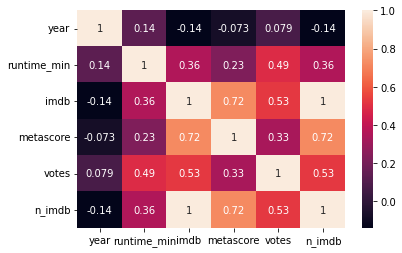

In [ ]:
sns.heatmap(final_df.corr(), annot=True);

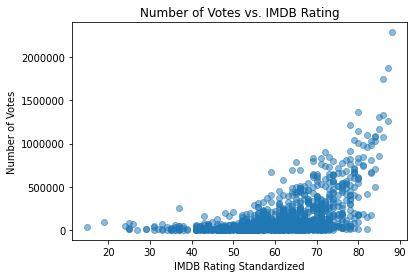

In [ ]:
x = final_df['n_imdb']
y = final_df['votes']
plt.scatter(x, y, alpha=0.5) # s= is size var, c= is color var
plt.xlabel("IMDB Rating Standardized")
plt.ylabel("Number of Votes")
plt.title("Number of Votes vs. IMDB Rating")
plt.ticklabel_format(style='plain')
plt.show()

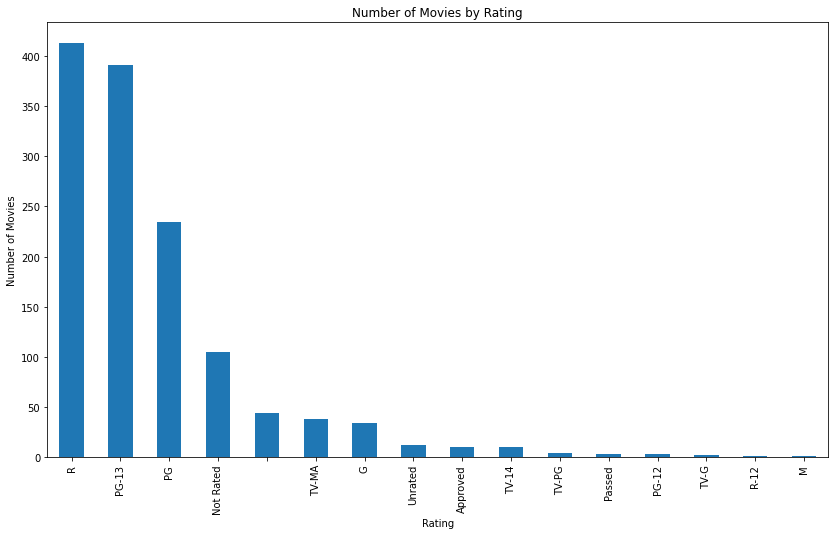

In [ ]:
ax = final_df['rating'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of Movies by Rating")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Movies")
ax.plot();

In [ ]:
final_df[final_df['rating'] == 'Approved']

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
53,Rollerball,1975,Approved,"[Action, Sci-Fi, Sport]",125,6.6,56,25028,66.0
603,Invasion of the Body Snatchers,1956,Approved,"[Drama, Horror, Sci-Fi]",80,7.7,92,49458,77.0
753,The Blob,1958,Approved,"[Horror, Sci-Fi]",86,6.3,58,26224,63.0
889,On the Beach,1959,Approved,"[Drama, Romance, Sci-Fi]",134,7.1,55,13053,71.0
958,Demon Seed,1977,Approved,"[Horror, Sci-Fi]",94,6.3,55,9065,63.0
1043,The Absent Minded Professor,1961,Approved,"[Comedy, Family, Sci-Fi]",92,6.7,75,8374,67.0
1076,The Curse of Frankenstein,1957,Approved,"[Horror, Sci-Fi, Thriller]",82,7.0,59,11116,70.0
1124,Children of the Damned,1964,Approved,"[Drama, Horror, Mystery]",89,6.2,42,4517,62.0
1154,Mighty Joe Young,1949,Approved,"[Adventure, Drama, Fantasy]",94,7.0,61,5278,70.0
1237,The Damned,1962,Approved,"[Drama, Fantasy, Horror]",87,6.6,72,3505,66.0


It looks like the "Approved" rating is an older movie rating that was perhaps phased out in later years? I couldn't find any representation of the Approved rating on the MPAA website which is evidence towards my claim that it has been phased out.

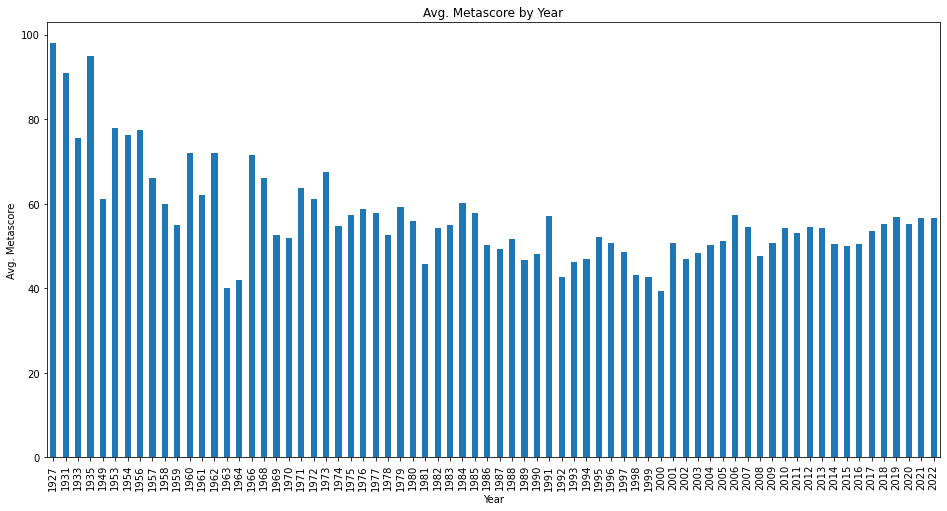

In [ ]:
# What are the average metascores by year?
final_df.groupby('year')['metascore'].mean().plot(kind='bar', figsize=(16,8), title="Avg. Metascore by Year", xlabel="Year", ylabel="Avg. Metascore")
plt.xticks(rotation=90)
plt.plot();

Looking at the above graph, one could say that for some reason movie metascores have gradually fallen since 1927 to this year, leveling out around 55-60 in the last couple decades.

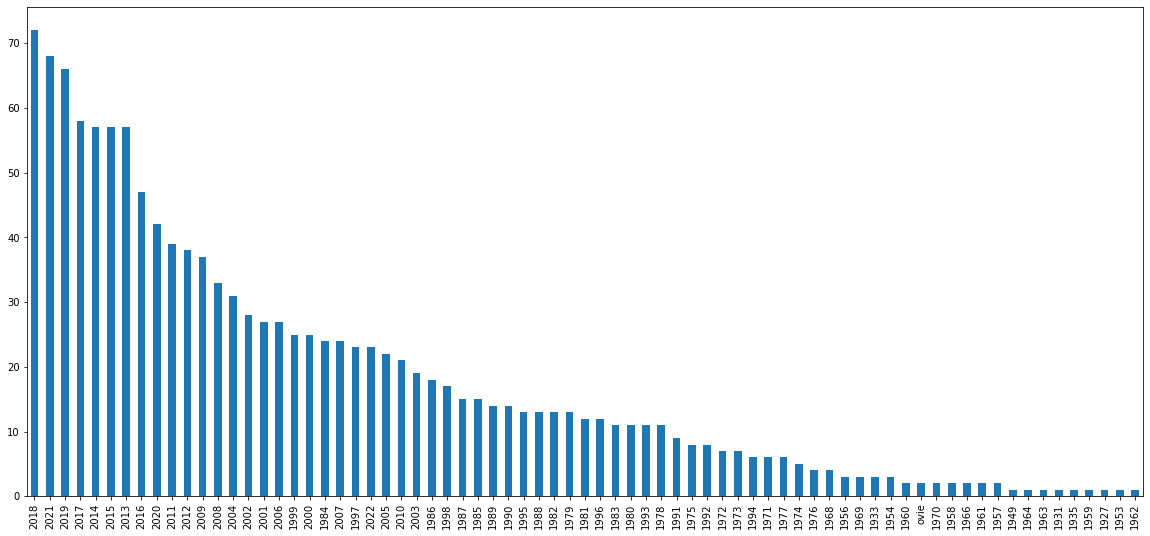

In [ ]:
final_df['year'].value_counts().plot(kind='bar', figsize=[20,9])

------

## Further Exploration

Now that you have gotten a handle of the data and explored it a bit, you can take this further and run predictive analyses or use Natural Language Processing (NLP) to uncover even more!

You could use NLP for example to see if there are any naming conventions to movie ratings, or within the world of Sci-Fi (or if you chose to do a different genre, whatever you choose!). You could also modify the webscraping code to pull many more genres by adding another for loop cycling through and inputting the different genres of interest into the base URL, and use this new inter-genre database to see if there are naming conventions by genre.

You could then try to predict the genre based on the name of the movie, or predict the IMDB rating based on the genre or the year the movie came out. The latter idea would probably work better in the last couple decades since that is where the majority of observations lie.
